In [1]:
import tensorflow as tf
import os

# Add this at the very top
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Restrict TensorFlow to only allocate memory dynamically
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

# Load libraries
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import math
import time
from pathlib import Path
from Resnet3D_model import Resnet3DBuilder
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, roc_curve, accuracy_score, recall_score, confusion_matrix
from data_utils_CV import get_paths_and_labels, calculate_min_max, create_dataset, clean_zone_identifier_files, extract_subject_id
from plotting_utils import view_image, view_random_image, plot_loss_curves, make_confusion_matrix, view_image_data
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedGroupKFold
import gc

2025-04-26 15:24:28.881855: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-26 15:24:29.404102: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


1 Physical GPUs, 1 Logical GPUs


2025-04-26 15:24:30.507142: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-26 15:24:30.528982: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-26 15:24:30.529037: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-26 15:24:30.531453: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-26 15:24:30.531500: I external/local_xla/xla/stream_executor

In [2]:
# Set seeds for reproducibility
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"Seeds set for reproducibility (seed={seed})")
print(f"PYTHONHASHSEED set to: {os.environ.get('PYTHONHASHSEED')}")

Seeds set for reproducibility (seed=42)
PYTHONHASHSEED set to: 42


In [3]:
# Set mixed precision policy to 'mixed_float16'
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
print('Mixed precision policy set to:', policy.name)

Mixed precision policy set to: mixed_float16


In [4]:
VOLUME_SHAPE = (91, 109, 91) # Expected volume shape of the PET nifti images
NORMALIZATION = "mni_reg_CV" # Choose intensity normalization method: "minmax"
DATASET = "smci_pmci" # Choose dataset: "smci_pmci" or "nc_ad"
BATCH_SIZE = 4 # Choose batch size

DATA_DIR = Path("/home/diogommiranda/tese/datasets/") / NORMALIZATION / DATASET
#ROI_MASK_PATH = str(Path("/home/diogommiranda/tese/masks/ROI_MASK.nii"))
ROI_MASK_PATH = None 

# Get train paths and labels to calculate minmax values
train_paths, train_labels_list, class_map = get_paths_and_labels(DATA_DIR, 'train')
train_paths = np.array(train_paths)
train_labels = np.array(train_labels_list)

# Calculate minmax values for train set
minmax_min, minmax_max = calculate_min_max(train_paths)

# Create test set with the minmax values from train
test_paths, test_labels, _ = get_paths_and_labels(DATA_DIR, 'test', class_map=class_map)
test_data = create_dataset(
    paths=test_paths,
    labels=test_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=False,
    seed=None,
    min_val=minmax_min, 
    max_val=minmax_max,
    mask_path=None
    )

Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/train...
Found 575 files for class 'smci'
Found 314 files for class 'pmci'
Calculating minmax across 889 files...
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/test...
Found 143 files for class 'smci'
Found 78 files for class 'pmci'

No mask applied.



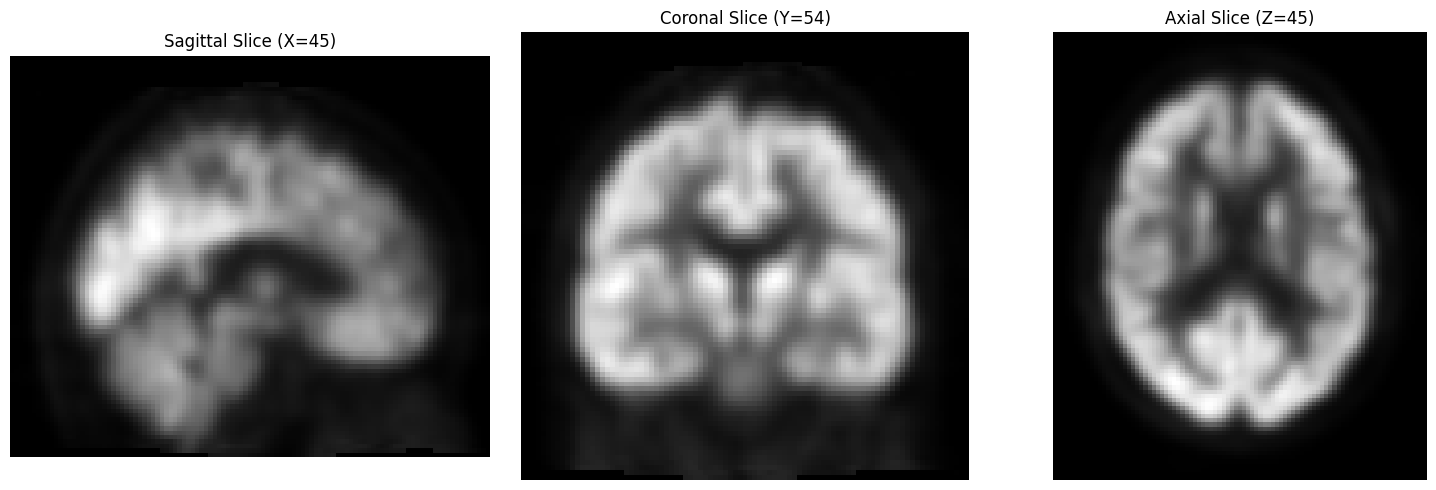

In [5]:
# verify a test sample
for data, label in test_data:
    view_image_data(data[0])
    break

In [ ]:
N_SPLITS = 5 # Number of splits for cross-validation
NUM_EPOCHS = 100 # Number of epochs for training
DROPOUT_RATE = 0.0 # Dropout rate for the model
REDUCE_LR_FACTOR = 0.2 # Factor to reduce learning rate (lr_reducer)
REDUCE_LR_PATIENCE = 6 # Patience for reducing learning rate (lr_reducer)
REDUCE_LR_MIN = 1e-7 # Minimum learning rate (lr_reducer)
EARLY_STOP_PATIENCE = 20 # Patience for early stopping (early_stopper)

# considerar learning rate=1e-3 se for com cosine decay
#learning_rates_to_try = [5e-4, 2e-4, 1e-4] 
#reg_factors_to_try = [5e-4, 2e-4, 1e-4]
reg_factors_to_try = [5e-4]
learning_rates_to_try = [2e-4]

tuning_results = []
total_combinations = len(learning_rates_to_try) * len(reg_factors_to_try)
current_combination_no = 0

SAVE_DATA = True # Save training data and plots

if SAVE_DATA:
    if ROI_MASK_PATH is None:
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/cosine_decay_tests/CROSS VALIDATION/results_resnet34/"
        os.makedirs(RESULTS_BASE_DIR, exist_ok=True)
        print(f"Results will be saved to: {RESULTS_BASE_DIR}")
    else:
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/testes_mask/cosine_decay/CROSS VALIDATION/results_resnet34/"
        os.makedirs(RESULTS_BASE_DIR, exist_ok=True)
        print(f"Results will be saved to: {RESULTS_BASE_DIR}")

# Set up StratifiedGroupKFold by subjects
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
subject_ids_list = [extract_subject_id(p) for p in train_paths]
subject_ids = np.array(subject_ids_list)

print("\nStarting Hyperparameter Tuning Grid Search...")
overall_start_time = time.time()

for current_lr in learning_rates_to_try:
    for current_reg in reg_factors_to_try:
        current_combination_no += 1
        print("=" * 60)
        print(f"Testing Combination {current_combination_no}/{total_combinations}: LR={current_lr}, L2_Reg={current_reg}")
        print("=" * 60)
        start_time_combination = time.time()
        
        combo_dir_name = f"LR0_{current_lr}_L2_{current_reg}"
        combo_results_dir = os.path.join(RESULTS_BASE_DIR, combo_dir_name)
        os.makedirs(combo_results_dir, exist_ok=True)
        print(f"  Saving results for this combo to: {combo_results_dir}")
        
        # Store results for the current hyperparameter combination
        current_combo_losses = []
        current_combo_accuracies = []
        current_combo_aucs = []
        current_combo_best_epoch = []

        # Store results for each fold
        fold_val_losses = []
        fold_val_accuracies = []
        fold_val_aucs = []
        fold_no = 1

        # K-Fold Cross-Validation
        for train_indices, val_indices in sgkf.split(train_paths, train_labels, groups=subject_ids):
            print("-" * 60)
            print(f"Training Fold {fold_no}/{N_SPLITS} for LR={current_lr} and Reg={current_reg}...")
            start_time_fold = time.time()

            # Get the paths and labels for the current fold
            fold_train_paths = train_paths[train_indices]
            fold_train_labels = train_labels[train_indices]
            fold_val_paths = train_paths[val_indices]
            fold_val_labels = train_labels[val_indices]

            # Verify that the training and validation sets have no overlapping subjects
            train_subjects = set(subject_ids[train_indices])
            val_subjects = set(subject_ids[val_indices])
            if not train_subjects.isdisjoint(val_subjects):
                print(f"WARNING: Fold {fold_no} has overlapping subjects!")
                break
            print(f"  Train samples: {len(fold_train_paths)}, Validation samples: {len(fold_val_paths)}")

            # Calculate minmax parameters for the current training fold
            fold_min, fold_max = calculate_min_max(fold_train_paths)

            # Create fold train dataset
            fold_train_data = create_dataset(
                paths=fold_train_paths,
                labels=fold_train_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=True, 
                seed=seed,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=None
            )
            
            # Create fold validation dataset
            fold_val_data = create_dataset(
                paths=fold_val_paths,
                labels=fold_val_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=False, 
                seed=None,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=None
            )

            if fold_train_data is None or fold_val_data is None:
                print(f"ERROR: Could not create datasets for fold {fold_no}. Skipping.")
                break

            # Compute class weights for the current fold
            unique_classes, class_counts = np.unique(fold_train_labels, return_counts=True)
            print(f"  Fold train label counts: {dict(zip(unique_classes, class_counts))}")
            fold_class_weights = class_weight.compute_class_weight('balanced', classes=unique_classes, y=fold_train_labels)
            fold_class_weight_dict = dict(zip(unique_classes, fold_class_weights))
            print(f"  Fold Class Weights: {fold_class_weight_dict}")

            tf.keras.backend.clear_session()
            # Build the model
            model = Resnet3DBuilder.build_resnet_34((91, 109, 91, 1), 1, reg_factor=current_reg, dropout_rate=DROPOUT_RATE)
    
            # Cosine decay scheduler
            steps_per_epoch = math.ceil(len(fold_train_data) / BATCH_SIZE)
            decay_steps = steps_per_epoch * NUM_EPOCHS
            COSINE_ALPHA_FACTOR = 1e-6/current_lr # Alpha factor for cosine decay: finishes last epoch (NUM_EPOCHS) in 1e-6
    
            # Choose either cosine_decay or lr_reducer
            cosine_decay = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=current_lr,
                                                                     decay_steps=decay_steps,
                                                                     alpha=COSINE_ALPHA_FACTOR,
                                                                     name='CosineDecay')
    
            #lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
            #                                                  factor=REDUCE_LR_FACTOR,
            #                                                  patience=REDUCE_LR_PATIENCE,
            #                                                  min_lr=REDUCE_LR_MIN,
            #                                                  verbose=1)
 
            early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=EARLY_STOP_PATIENCE,
                                                            restore_best_weights=True,
                                                            verbose=1)
    
            callbacks_list = [early_stopper]

            auc_metric = tf.keras.metrics.AUC(name='auc')

            # Compile the model
            model.compile(loss="binary_crossentropy",
                        optimizer= tf.keras.optimizers.Adam(learning_rate=cosine_decay, # for tuning
                                                            clipnorm=1.0),
                        metrics=["accuracy", auc_metric])

            history = model.fit(
                fold_train_data,
                epochs=NUM_EPOCHS,
                validation_data=fold_val_data,
                class_weight=fold_class_weight_dict,
                verbose=1,
                callbacks=callbacks_list
            )
            
            # Save the data for current fold
            if SAVE_DATA:
                fold_dir = os.path.join(combo_results_dir, f"fold_{fold_no}")
                os.makedirs(fold_dir, exist_ok=True)
                history_df = pd.DataFrame(history.history)
                history_df.insert(0, 'epoch', range(1, len(history_df) + 1))
                history_csv_path = os.path.join(fold_dir, f"history_fold_{fold_no}.csv")
                try:
                    history_df.to_csv(history_csv_path, index=False)
                    print(f"  History saved to: {history_csv_path}")
                except Exception as e:
                    print(f"  Error saving history: {e}")
                # Save plots
                plot_loss_curves(history, fold_dir)

            # Evaluate the fold
            best_epoch_index = np.argmin(history.history['val_loss'])
            best_epoch = best_epoch_index + 1
            val_loss_best = history.history['val_loss'][best_epoch_index]
            val_accuracy_best = history.history['val_accuracy'][best_epoch_index]
            val_auc_best = history.history['val_auc'][best_epoch_index]
            print(f"    Fold {fold_no} - Best Epoch {best_epoch}: Val Loss={val_loss_best:.4f}, Acc={val_accuracy_best:.4f}, AUC={val_auc_best:.4f}")
    
            current_combo_losses.append(val_loss_best)
            current_combo_accuracies.append(val_accuracy_best)
            current_combo_aucs.append(val_auc_best)
            current_combo_best_epoch.append(best_epoch)

            # Clean up
            del history_df
            del history 
            del fold_train_data
            del fold_val_data
            del model
            tf.keras.backend.clear_session()
            gc.collect()

            end_time_fold = time.time()
            print(f"    Fold {fold_no} finished in {end_time_fold - start_time_fold:.2f} seconds.")
            fold_no += 1

        # Aggregate results for the current hyperparameter combination
        if len(current_combo_losses) == N_SPLITS:
            avg_loss = np.mean(current_combo_losses)
            std_loss = np.std(current_combo_losses)
            avg_acc = np.mean(current_combo_accuracies)
            std_acc = np.std(current_combo_accuracies)
            avg_auc = np.mean(current_combo_aucs)
            std_auc = np.std(current_combo_aucs)

            print("-" * 50)
            print(f"Results for LR={current_lr}, L2_Reg={current_reg} (Across {N_SPLITS} Folds):")
            print(f"  Avg Val Loss: {avg_loss:.4f} +/- {std_loss:.4f}")
            print(f"  Avg Val Acc:  {avg_acc:.4f} +/- {std_acc:.4f}")
            print(f"  Avg Val AUC:  {avg_auc:.4f} +/- {std_auc:.4f}")
            print("-" * 50)
            

            # Store results
            tuning_results.append({
                'learning_rate': current_lr,
                'reg_factor': current_reg,
                'avg_val_loss': avg_loss,
                'std_val_loss': std_loss,
                'avg_val_accuracy': avg_acc,
                'std_val_accuracy': std_acc,
                'avg_val_auc': avg_auc,
                'std_val_auc': std_auc,
                'individual_losses': [round(loss, 4) for loss in current_combo_losses],
                'individual_accuracies': [round(acc, 4) for acc in current_combo_accuracies],
                'individual_aucs': [round(auc, 4) for auc in current_combo_aucs],
                'best_epoch_per_fold': list(current_combo_best_epoch)
            })

        end_time_combination = time.time()
        print(f"Combination {current_combination_no} finished in {end_time_combination - start_time_combination:.2f} seconds.") 


Results will be saved to: /home/diogommiranda/tese/cosine_decay_tests/CROSS VALIDATION/results_resnet34/

Starting Hyperparameter Tuning Grid Search...
Testing Combination 1/1: LR=0.0002, L2_Reg=0.0005
  Saving results for this combo to: /home/diogommiranda/tese/cosine_decay_tests/CROSS VALIDATION/results_resnet34/LR0_0.0002_L2_0.0005
------------------------------------------------------------
Training Fold 1/5 for LR=0.0002 and Reg=0.0005...
  Train samples: 706, Validation samples: 183
Calculating minmax across 706 files...
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
Shuffling with buffer size: 706

No mask applied.


No mask applied.

  Fold train label counts: {0: 456, 1: 250}
  Fold Class Weights: {0: 0.7741228070175439, 1: 1.412}
here CHANNELS last
Epoch 1/100


I0000 00:00:1745677491.627774  362576 service.cc:145] XLA service 0x7f8950004370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745677491.627888  362576 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-04-26 15:24:53.402209: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-26 15:24:55.667701: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1745677507.186387  362576 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_32', 536 bytes spill stores, 536 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_31', 280 bytes spill stores, 280 bytes spill loads
ptxas warning : Registers are spilled to local memory i

176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7764 - auc: 0.8060 - loss: 7.3111

I0000 00:00:1745677531.678394  362576 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_32', 48 bytes spill stores, 48 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_28', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_29', 4 bytes spill stores, 4 bytes spill loads



177/177 ━━━━━━━━━━━━━━━━━━━━ 59s 171ms/step - accuracy: 0.7767 - auc: 0.8064 - loss: 7.3009 - val_accuracy: 0.6776 - val_auc: 0.7775 - val_loss: 4.9897
Epoch 2/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.8013 - auc: 0.8398 - loss: 4.4620 - val_accuracy: 0.6503 - val_auc: 0.7969 - val_loss: 4.3076
Epoch 3/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.8282 - auc: 0.9003 - loss: 3.2073 - val_accuracy: 0.3497 - val_auc: 0.7753 - val_loss: 3.7160
Epoch 4/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.8508 - auc: 0.9230 - loss: 2.5666 - val_accuracy: 0.3497 - val_auc: 0.8006 - val_loss: 4.3067
Epoch 5/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.9014 - auc: 0.9498 - loss: 2.1149 - val_accuracy: 0.5082 - val_auc: 0.7945 - val_loss: 3.0458
Epoch 6/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.9106 - auc: 0.9662 - loss: 1.8651 - val_accuracy: 0.3497 - val_auc: 0.7945 - val_loss: 3.6022
Epoch 7/100
177/177 ━━━━━━━━━━━━━

2025-04-26 16:03:31.663083: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16777248 bytes after encountering the first element of size 16777248 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.8737 - auc: 0.9416 - loss: 2.5010 - val_accuracy: 0.5607 - val_auc: 0.7956 - val_loss: 2.8394
Epoch 5/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.8823 - auc: 0.9229 - loss: 2.2716 - val_accuracy: 0.5607 - val_auc: 0.7288 - val_loss: 2.5020
Epoch 6/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.9264 - auc: 0.9617 - loss: 1.9063 - val_accuracy: 0.5029 - val_auc: 0.7802 - val_loss: 2.7510
Epoch 7/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9288 - auc: 0.9773 - loss: 1.6909 - val_accuracy: 0.6301 - val_auc: 0.6806 - val_loss: 2.0768
Epoch 8/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.9453 - auc: 0.9685 - loss: 1.6305 - val_accuracy: 0.6590 - val_auc: 0.7577 - val_loss: 1.9077
Epoch 9/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.9345 - auc: 0.9763 - loss: 1.4879 - val_accuracy: 0.6069 - val_auc: 0.7646 - val_loss: 2.0305
Epoch 10/100
179/179 ━━━━━━━━━━━━

2025-04-26 16:06:57.734002: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 14442528 bytes after encountering the first element of size 14442528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - accuracy: 0.9981 - auc: 1.0000 - loss: 0.9106 - val_accuracy: 0.7514 - val_auc: 0.8449 - val_loss: 1.6084
Epoch 18/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.9959 - auc: 1.0000 - loss: 0.8882 - val_accuracy: 0.7630 - val_auc: 0.8410 - val_loss: 1.5407
Epoch 19/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.8517 - val_accuracy: 0.7399 - val_auc: 0.8363 - val_loss: 1.6119
Epoch 20/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.8329 - val_accuracy: 0.7630 - val_auc: 0.8367 - val_loss: 1.4622
Epoch 21/100
  1/179 ━━━━━━━━━━━━━━━━━━━━ 29s 166ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.8201

2025-04-26 16:07:58.521298: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16777248 bytes after encountering the first element of size 16777248 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.8206 - val_accuracy: 0.7399 - val_auc: 0.8438 - val_loss: 1.6142
Epoch 22/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.8093 - val_accuracy: 0.7283 - val_auc: 0.8349 - val_loss: 1.6949
Epoch 23/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.8010 - val_accuracy: 0.7457 - val_auc: 0.8334 - val_loss: 1.7498
Epoch 24/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.7993 - val_accuracy: 0.7341 - val_auc: 0.8374 - val_loss: 1.6781
Epoch 25/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 1.0000 - auc: 0.9944 - loss: 0.7970 - val_accuracy: 0.7399 - val_auc: 0.8357 - val_loss: 1.6719
Epoch 26/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.7935 - val_accuracy: 0.7341 - val_auc: 0.8398 - val_loss: 1.7067
Epoch 27/100
179/179 ━━━━━━━━

2025-04-26 16:10:30.892972: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16777248 bytes after encountering the first element of size 16777248 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.7885 - val_accuracy: 0.7399 - val_auc: 0.8340 - val_loss: 1.7399
Epoch 32/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.7894 - val_accuracy: 0.7283 - val_auc: 0.8381 - val_loss: 1.7048
Epoch 33/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.7846 - val_accuracy: 0.7341 - val_auc: 0.8350 - val_loss: 1.7366
Epoch 34/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 1.0000 - auc: 0.9944 - loss: 0.7861 - val_accuracy: 0.7341 - val_auc: 0.8337 - val_loss: 1.7148
Epoch 35/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 1.0000 - auc: 0.9944 - loss: 0.7829 - val_accuracy: 0.7341 - val_auc: 0.8344 - val_loss: 1.7333
Epoch 36/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 1.0000 - auc: 0.9944 - loss: 0.7815 - val_accuracy: 0.7399 - val_auc: 0.8358 - val_loss: 1.7452
Epoch 37/100
179/179 ━━━━━━━━

In [8]:
print("=" * 60)
if not tuning_results:
    print("No tuning results were recorded.")
else:
    
    results_df = pd.DataFrame(tuning_results)
    results_df = results_df.sort_values(by='avg_val_loss', ascending=False)

    print("\nTuning Results Summary:")
    display_cols = ['learning_rate', 'reg_factor', 'avg_val_loss', 'avg_val_accuracy', 'avg_val_auc', 'std_val_loss', 'std_val_accuracy', 'std_val_auc', 'individual_losses', 'individual_accuracies', 'individual_aucs', 'best_epoch_per_fold']
    print(results_df[display_cols].round(4))

    best_combination = results_df.iloc[0]

    print("\n --- Best Hyperparameters Found ---")
    print(best_combination[display_cols])

    best_lr_final = best_combination['learning_rate']
    best_reg_final = best_combination['reg_factor']
    print(f"\nSelected best parameters: LR={best_lr_final}, L2_Reg={best_reg_final}")


Tuning Results Summary:
   learning_rate  reg_factor  avg_val_loss  avg_val_accuracy  avg_val_auc  \
0         0.0002      0.0005        1.4828             0.782       0.8443   

   std_val_loss  std_val_accuracy  std_val_auc  \
0        0.2378            0.0771       0.0692   

                          individual_losses  \
0  [1.9409, 1.3285, 1.2758, 1.4066, 1.4622]   

                   individual_accuracies  \
0  [0.6667, 0.8409, 0.8895, 0.75, 0.763]   

                            individual_aucs   best_epoch_per_fold  
0  [0.7233, 0.9011, 0.9219, 0.8385, 0.8367]  [11, 17, 24, 18, 20]  

 --- Best Hyperparameters Found ---
learning_rate                                              0.0002
reg_factor                                                 0.0005
avg_val_loss                                             1.482795
avg_val_accuracy                                         0.782017
avg_val_auc                                              0.844294
std_val_loss                    